# 01. PyTorch Workflow Fundamentals

## What we're going to cover

In this module we're going to cover a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

For now, we'll use this workflow to predict a simple straight line but the workflow steps can be repeated and changed depending on the problem you're working on.

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, here we'll cover that. |
| **6. Putting it all together** | Let's take all of the above and combine it. |

## Plans

In [87]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [88]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.0.post200'

In [89]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [90]:
# device

# 1. Data (preparing and loading)

In [91]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data into training and test sets 

We've got some data.

But before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` tensors.

> **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.


In [92]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [93]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    """Plot training data, test data and compare predictions"""
    plt.figure(figsize=(10, 7))

    # Train by blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Train")

    # Test by green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test")

    if predictions is not None:
        # Predict by red
        plt.scatter(test_data, predictions, c="r", s=4, label="Predict")

    plt.legend()

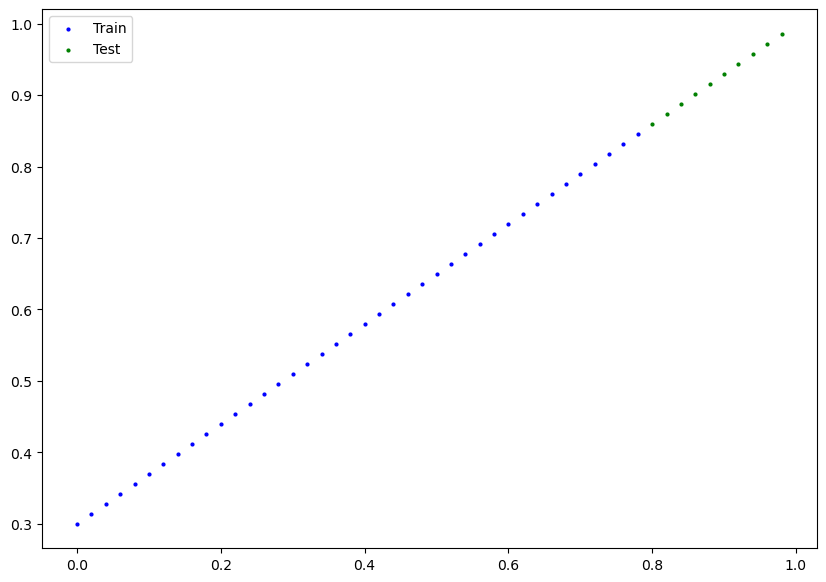

In [94]:
plot_predictions()

## Build Model!

In [95]:
# Linear Regression class
class LinearRegression(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float64), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float64), requires_grad=True)
        # start with random weights (this will get adjusted as the model learns)
        # if i wanna do new parametr -> nn.Parametr()
        # requires_grad -> updates if grad descent AUTOMAT

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """Forward defines the computation in the model"""
        return self.weights * x + self.bias

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their uses cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html). 


In [96]:
torch.manual_seed(42)

model = LinearRegression()

list(model.parameters())

[Parameter containing:
 tensor([0.3367], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.1288], dtype=torch.float64, requires_grad=True)]

In [97]:
model.state_dict()

OrderedDict([('weights', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

In [98]:
# Make predictions
with torch.inference_mode():
    y_preds = model(X_test)


In [99]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)

In [100]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)


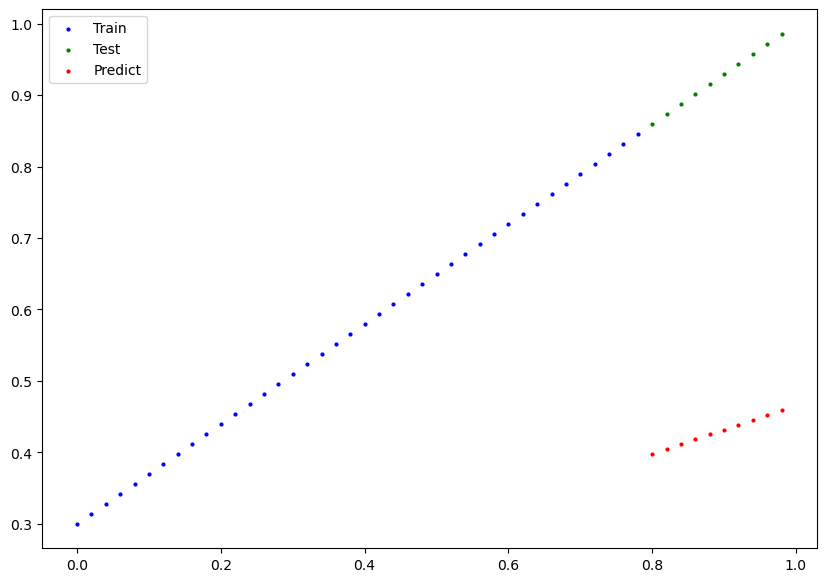

In [101]:
plot_predictions(predictions=y_preds)

In [102]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

### Creating an optimization loop in PyTorch

Woohoo! Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **testing loop**).

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

To create these we're going to write a Python `for` loop in the theme of the [unofficial PyTorch optimization loop song](https://twitter.com/mrdbourke/status/1450977868406673410?s=20) (there's a [video version too](https://youtu.be/Nutpusq_AFw)).

![the unofficial pytorch optimization loop song](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-optimization-loop-song.png)
*The unoffical PyTorch optimization loops song, a fun way to remember the steps in a PyTorch training (and testing) loop.*

There will be a fair bit of code but nothing we can't handle.




### PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> **Note:** The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
>
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb: 
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* stepping them (`optimizer.step()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).

For resources to help understand what's happening behind the scenes with backpropagation and gradient descent, see the extra-curriculum section.



### PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` | 
| 3 | Calulate evaluation metrics (optional) | Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.


In [103]:
torch.manual_seed(42)
epochs = 160
train_loss_values, test_loss_values, epoch_count = [], [], []

for epoch in range(epochs):
    # Train
    model.train()
    y_pred = model(X_train) # Forward
    loss = loss_fn(y_pred, y_train) # Loss fn
    optimizer.zero_grad() # Zero grad to optimize
    loss.backward() # Loss backward
    optimizer.step() # Optimizer step
    model.eval() # Evaluate model

    # Test
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288135683755547 | MAE Test Loss: 0.4810651841540759 
Epoch: 10 | MAE Train Loss: 0.1976713574739093 | MAE Test Loss: 0.346355184508239 
Epoch: 20 | MAE Train Loss: 0.08908721056311557 | MAE Test Loss: 0.21729648486064157 
Epoch: 30 | MAE Train Loss: 0.05314849742260115 | MAE Test Loss: 0.14464008519991425 
Epoch: 40 | MAE Train Loss: 0.04543793101588776 | MAE Test Loss: 0.11360938544629148 
Epoch: 50 | MAE Train Loss: 0.041678606478126046 | MAE Test Loss: 0.09919938569279392 
Epoch: 60 | MAE Train Loss: 0.03818929484512264 | MAE Test Loss: 0.08886628595826254 
Epoch: 70 | MAE Train Loss: 0.03476085499350197 | MAE Test Loss: 0.08059388621223337 
Epoch: 80 | MAE Train Loss: 0.031323806993240874 | MAE Test Loss: 0.07232148646620422 
Epoch: 90 | MAE Train Loss: 0.02788736528831538 | MAE Test Loss: 0.06473598671634251 
Epoch: 100 | MAE Train Loss: 0.024458925436694718 | MAE Test Loss: 0.056463586970313374 
Epoch: 110 | MAE Train Loss: 0.021020207499473125 | MA

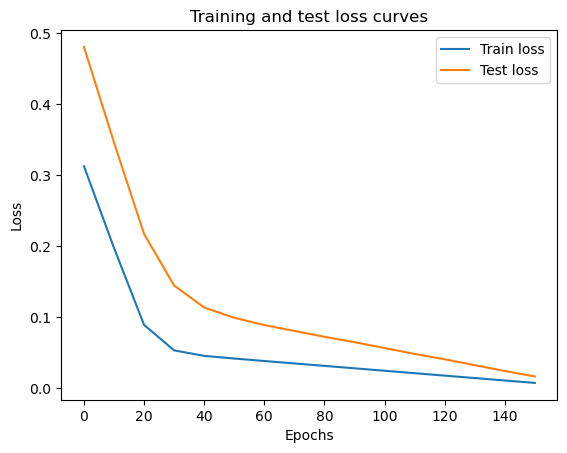

In [104]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [105]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6808], dtype=torch.float64)), ('bias', tensor([0.3078], dtype=torch.float64))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# Make predictions

In [106]:
model.eval()

with torch.inference_mode():
    # model.to(device)
    # X_test = X_test.to(device)
    y_preds = model(X_test)

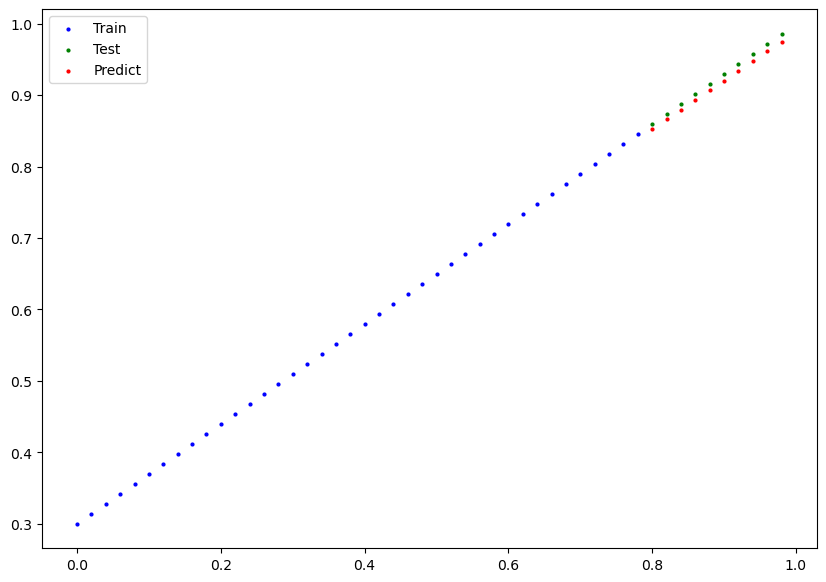

In [107]:
plot_predictions(predictions=y_preds)

# Save model

## 5. Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it. 

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method | What does it do? | 
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialzed object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  | 
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. | 

> **Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.


In [108]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


# Load model

In [110]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegression()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [111]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [112]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])